# Exploratory Data Analysis (Formatted Zone)
Complex Seasonality Analysis

In [1]:
import datetime

from database_settings import postgres_utilities
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from exploratory_data_analysis.formatted import utilities

## Get the time series


In [2]:
# Establish the connection with the Persistent Zone
engine = postgres_utilities.engine()
# Filters
net_weight_threshold = 100
value_usd_threshold = 200
headings_count_threshold = 100
year_threshold = 2017
# Get all the data filtered
df = pd.DataFrame(postgres_utilities.run_query_file(engine,
                                           './queries/heading_data.sql',
                                           params={'year_threshold': year_threshold,
                                                   'headings_count_threshold': headings_count_threshold,
                                                   'value_usd_threshold': value_usd_threshold,
                                                   'net_weight_threshold': net_weight_threshold}))

Connected to Formatted Zone successfully!


In [3]:
# Select a random heading (optionally, select a exporter)
heading, description, exporter = df.sample()[['heading','description', 'exporter_id']].iloc[0]
print('Heading: {}, Description: {}'.format(heading,description))
heading_data = df[(df['heading']==heading)].copy()

Heading: 0804502000, Description: Mangos y mangostanes frescos o secos


In [4]:
# Generate the time granularities
start_date = heading_data['boarding_date'].min()
end_date = heading_data['boarding_date'].max()

time_granularities = utilities.generate_time_granularities(start_date,end_date)

# import datetime
#
# start_date = datetime.date(2017,1,1)
# end_date = datetime.date(2023,4,29)
#
#
# time_granularities = pd.date_range(start=start_date, end=end_date, freq='D')
# time_granularities = pd.DataFrame(index=time_granularities)
time_granularities

,year,semester_in_year,quarter_in_year,month_in_year,month_in_semester,month_in_quarter,quarter_in_semester,day_in_year,day_in_semester,day_in_quarter,day_in_month,day_in_week,week_in_year,week_in_semester,week_in_quarter,week_in_month
2017-01-01,2017,1,1,1,1,1,1,1,1,1,1,7,52,26,13,5
2017-01-02,2017,1,1,1,1,1,1,2,2,2,2,1,1,1,1,1
2017-01-03,2017,1,1,1,1,1,1,3,3,3,3,2,1,1,1,1
2017-01-04,2017,1,1,1,1,1,1,4,4,4,4,3,1,1,1,1
2017-01-05,2017,1,1,1,1,1,1,5,5,5,5,4,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-14,2023,1,2,4,4,1,2,104,104,14,14,5,15,15,2,2
2023-04-15,2023,1,2,4,4,1,2,105,105,15,15,6,15,15,2,2
2023-04-16,2023,1,2,4,4,1,2,106,106,16,16,7,15,15,2,2
2023-04-17,2023,1,2,4,4,1,2,107,107,17,17,1,16,16,3,3


### Daily kilogram's price time series

In [5]:
# usd/kg time series
heading_data['usd_kg'] = heading_data['value_usd']/heading_data['net_weight']
heading_data['usd_kg'] = heading_data['usd_kg'].astype(float)
heading_data['usd_kg'] = heading_data['usd_kg'].round(3)
# Group by boarding_date
usd_kg = heading_data[['boarding_date','usd_kg']].groupby(by=['boarding_date']).mean().round(3)
# Impute missing dates assigning the usd_kg of the day before
usd_kg.index = pd.to_datetime(usd_kg.index)
usd_kg = usd_kg.resample('D').ffill()
# Add the time granularities
usd_kg = pd.concat([usd_kg, time_granularities], axis=1)
usd_kg

,usd_kg,year,semester_in_year,quarter_in_year,month_in_year,month_in_semester,month_in_quarter,quarter_in_semester,day_in_year,day_in_semester,day_in_quarter,day_in_month,day_in_week,week_in_year,week_in_semester,week_in_quarter,week_in_month
2017-01-01,1.545,2017,1,1,1,1,1,1,1,1,1,1,7,52,26,13,5
2017-01-02,1.775,2017,1,1,1,1,1,1,2,2,2,2,1,1,1,1,1
2017-01-03,1.102,2017,1,1,1,1,1,1,3,3,3,3,2,1,1,1,1
2017-01-04,1.058,2017,1,1,1,1,1,1,4,4,4,4,3,1,1,1,1
2017-01-05,1.290,2017,1,1,1,1,1,1,5,5,5,5,4,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-14,3.034,2023,1,2,4,4,1,2,104,104,14,14,5,15,15,2,2
2023-04-15,2.491,2023,1,2,4,4,1,2,105,105,15,15,6,15,15,2,2
2023-04-16,2.525,2023,1,2,4,4,1,2,106,106,16,16,7,15,15,2,2
2023-04-17,2.788,2023,1,2,4,4,1,2,107,107,17,17,1,16,16,3,3


### Daily total (net) weight exporter time series

In [6]:
# total net weight time series
# Group by boarding_date
net_weight = heading_data[['boarding_date','net_weight']].groupby(by=['boarding_date']).sum().round(3)
# Impute missing dates assigning 0 kg for days without shipments
net_weight.index = pd.to_datetime(net_weight.index)
net_weight = net_weight.resample('D').asfreq()
net_weight.fillna(0.0, inplace=True)
# Convert numerical columns to float
net_weight = net_weight.astype({'net_weight': 'float'})
# Add the time granularities
net_weight = pd.concat([net_weight, time_granularities], axis=1)

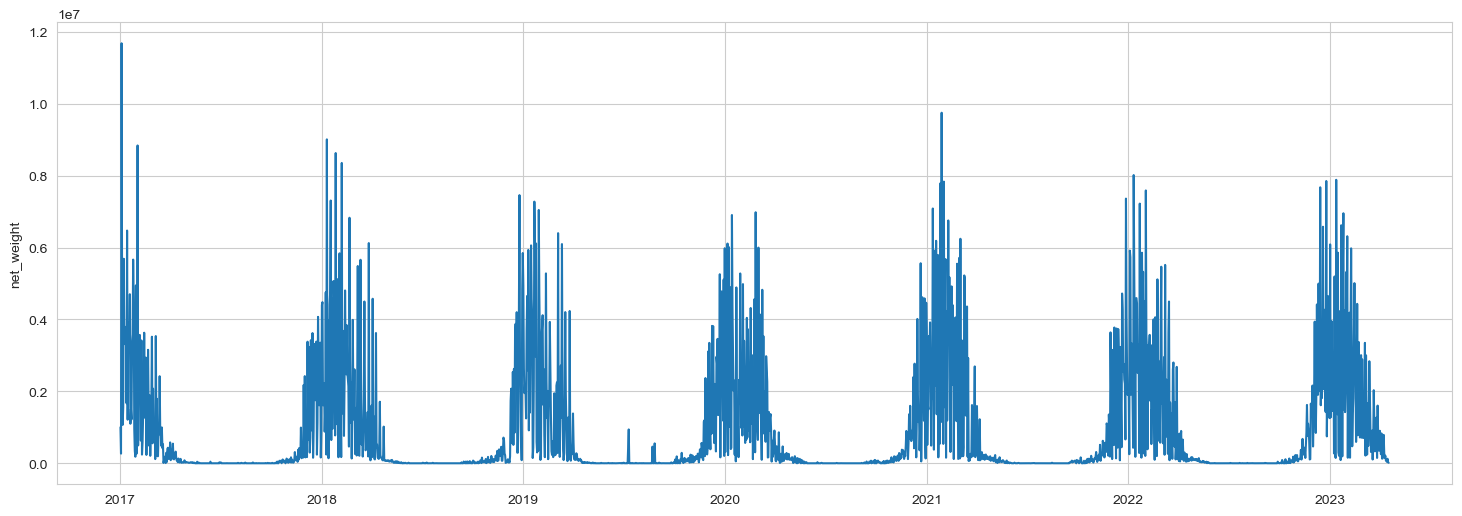

In [7]:
# Plot time series
plt.figure(figsize=(18,6))
sns.lineplot(x=net_weight.index, y="net_weight", data=net_weight)
plt.show()

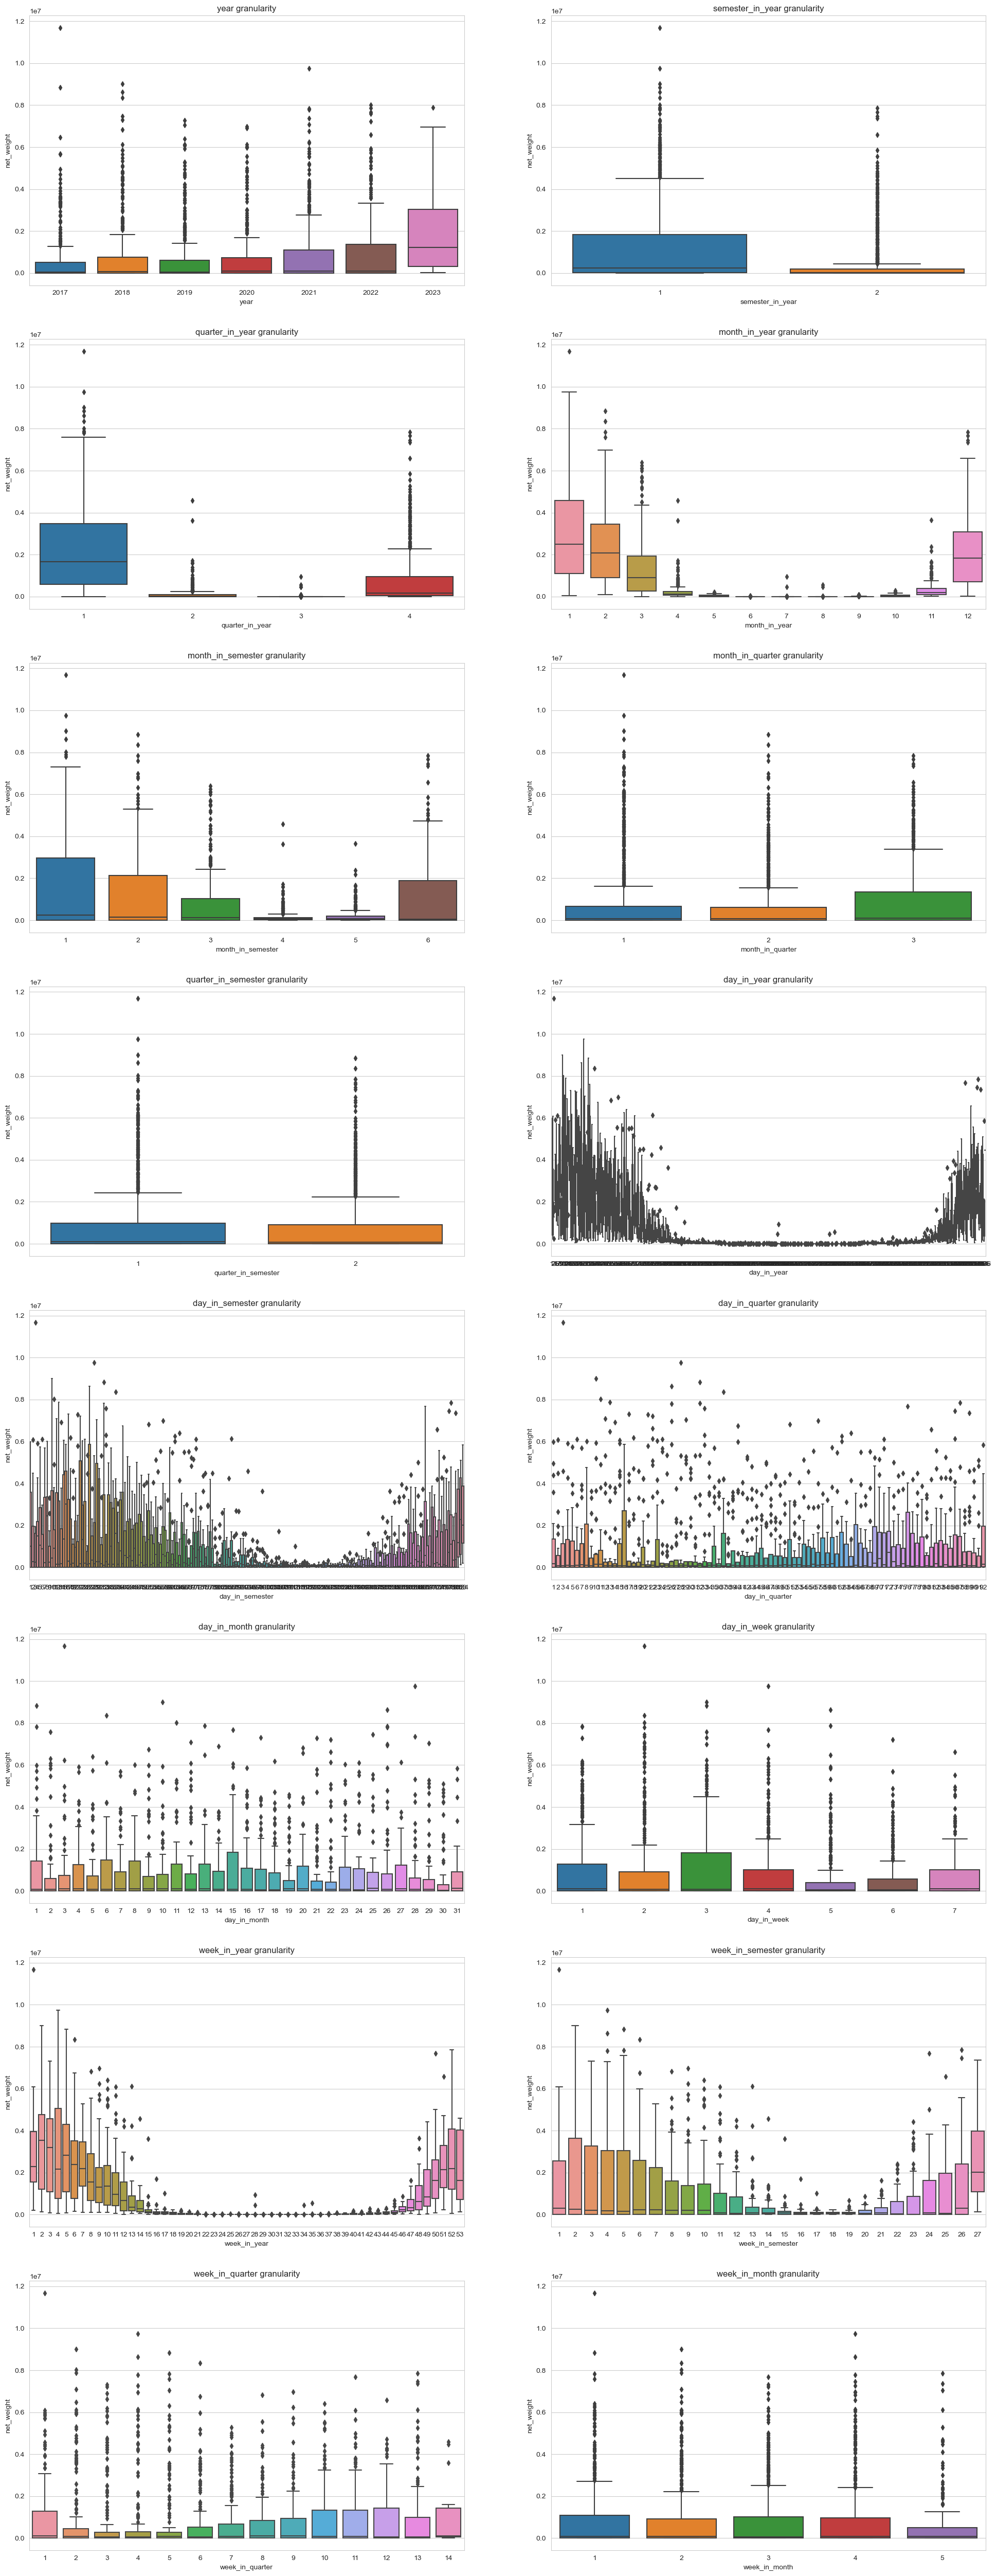

In [8]:
# Granularity plots

data = net_weight
target_column = 'net_weight'
columns = data.columns.tolist()
columns.remove(target_column)
num_columns = len(columns)
num_rows = (num_columns + 1) // 2

# Create the subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(24, num_rows*8))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over each column and create the corresponding subplot
for i, column in enumerate(columns):
    sns.boxplot(ax=axes[i],
                data=data,
                x=column,
                y=target_column,
                order=[str(i) for i in data[column].astype(int).sort_values().unique()])
    axes[i].set_title(f"{column} granularity")

# If the number of columns is odd, remove the last empty subplot
if num_columns % 2 != 0:
    fig.delaxes(axes[num_columns])

# Add a main title to the entire plot
# fig.suptitle('Granularity plots')

# Display the plot
plt.show()

In [ ]:
# Seasonal plot (yearly)
plt.figure(figsize=(18,6))
sns.scatterplot(x='day_in_quarter',
            y='net_weight',
            data = net_weight,
            #legend='full',
            #palette=sns.color_palette("dark:salmon_r", as_cmap=True),
            )
#plt.legend(bbox_to_anchor=(1, 1), loc=2);
plt.show()

In [ ]:
sns.boxplot(x=pd.to_datetime(net_weight['boarding_date']).dt.day,
            y=net_weight['net_weight'],
            hue=pd.to_datetime(net_weight['boarding_date']).dt.month)
plt.show()